# LEV / GSW overlay

Various methods for overlaying emergent lake vegetation rasters over Pekel/GSW inundation rasters. Occurrence seems to perform better than Seasonality.

In [3]:
## Imports
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from scipy.stats import binned_statistic
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd

In [4]:
## Env vars
reclass_vals_detailed = {
    1:	'dry land',
    2:	'water',
    3:	'wet graminoid',
    4:	'wet shrubs',
    5:	'wet forest',
    25: 'river or bridge',
    30: 'urban',
    35: 'non-roi',
    42:	'water no lake',
    43:	'wet graminoid no lake',
    44: 'wet shrubs no lake',
    45: 'wet forest no lake',
    52: 'water not valid'}

reclass_vals_simple = {
    1:	'dry land',
    2:	'water',
    3:	'LEV',
    4:	'LEV',
    5:	'LEV',
    25: 'invalid', 
    30: 'invalid', 
    35: 'invalid', 
    42:	'invalid', 
    43:	'invalid', 
    44: 'invalid', 
    45: 'invalid', 
    52: 'invalid'}

## Method A: Load from GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Zonal histogram based on DN field

In Python:
1. Aggregate by class
2. Compute confusion matrix and plot histograms

In [74]:
## I/O
# region = 'YB'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/YFLATS_190914_mosaic_rcls_brn_zHist_Oc.shp' # this is zonal histogram of YF UAVSAR against GSW Occurrence
region = 'CSB'
df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'
# region = 'PAD'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'

## Load
df = gpd.read_file(df_pth) 
df.head()

,DN,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_91,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,geometry
0,44,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-905490.936 2666178.821, -905484.858..."
1,4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-905503.092 2666178.821, -905497.014..."
2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-905563.872 2666154.509, -905557.794..."
3,1,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-905539.560 2666178.821, -905503.092..."
4,3,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-905569.950 2666148.431, -905563.872..."


In [75]:
## Add actual class name
df['Class'] = df['DN'].apply(lambda x: reclass_vals_detailed[x])
df['Broad_class'] = df['DN'].apply(lambda x: reclass_vals_simple[x])

In [76]:
# Aggregate by class (detailed)
dfg = df.groupby('Class')
df_sums = dfg.sum(numeric_only=True)
df_sums.drop(columns='DN', inplace=True) # drop meaningless columns
df_sums.loc['SUM', :]=df_sums.sum()

# Aggregate by class (simple)
dfgs = df.groupby('Broad_class')
df_sums_s = dfgs.sum(numeric_only=True)
df_sums_s.drop(columns='DN', inplace=True)
df_sums_s.loc['SUM', :]=df_sums_s.sum()

df_sums_s

,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,HISTO_9,...,HISTO_90,HISTO_91,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99
Broad_class,,,,,,,,,,,,,,,,,,,,,
LEV,126925.0,1082.0,930.0,856.0,728.0,680.0,704.0,677.0,734.0,688.0,...,1255.0,1561.0,1873.0,1727.0,1717.0,1318.0,822.0,400.0,80.0,2.0
dry land,2251960.0,1428.0,1100.0,918.0,763.0,792.0,1061.0,1126.0,1290.0,1247.0,...,2906.0,3744.0,3841.0,3172.0,2818.0,2210.0,1326.0,860.0,184.0,5.0
invalid,221581.0,208.0,206.0,177.0,179.0,217.0,267.0,242.0,252.0,275.0,...,1555.0,2054.0,2233.0,1960.0,1511.0,2728.0,5392.0,4269.0,1727.0,107.0
water,82204.0,1067.0,1118.0,1186.0,1005.0,995.0,820.0,665.0,801.0,773.0,...,39624.0,56859.0,75083.0,86912.0,83541.0,74616.0,59630.0,50380.0,17421.0,444.0
SUM,2682670.0,3785.0,3354.0,3137.0,2675.0,2684.0,2852.0,2710.0,3077.0,2983.0,...,45340.0,64218.0,83030.0,93771.0,89587.0,80872.0,67170.0,55909.0,19412.0,558.0


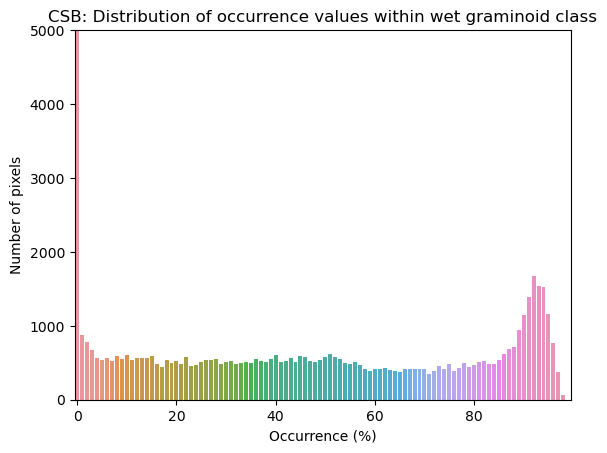

In [77]:
## Plot hist to show: "Within all wet graminoid pixels, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums.loc['wet graminoid', 'HISTO_0':] # 'HISTO_100'
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within wet graminoid class')
plt.show()

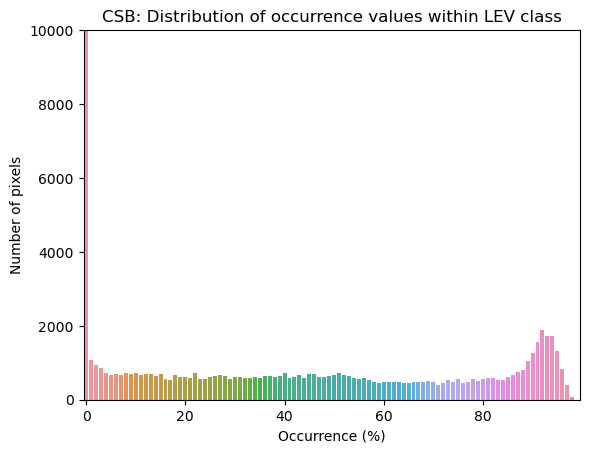

In [78]:
## Plot hist to show: "Within all LEV, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums_s.loc['LEV', 'HISTO_0':]
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 10000]) #5,000 for most sites, 10,000 for PAD
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()

### Now, group occurrence and calculate confusion matrix

In [79]:
## Compute binned statistic
stats_classes = ['LEV', 'dry land', 'water', 'SUM'] # 
bStat = binned_statistic(np.arange(df_sums_s.columns.size), values=df_sums_s.loc[stats_classes, :], statistic='sum', bins=[0, 5, 50, 95, 100]) # 
df_sums_s
bStat


BinnedStatisticResult(statistic=array([[1.305210e+05, 2.875500e+04, 3.042400e+04, 2.622000e+03],
       [2.256169e+06, 3.624500e+04, 4.426500e+04, 4.585000e+03],
       [8.658000e+04, 5.497600e+04, 4.780240e+05, 2.024910e+05],
       [2.695621e+06, 1.275050e+05, 5.697910e+05, 2.239210e+05]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]))

In [80]:
## Construct Confusion Matrix

cm = pd.DataFrame(bStat.statistic[[0, -1]], columns = bStat.bin_edges[1:], index = [stats_classes[0], stats_classes[-1]])
cm.loc['Other', :] = cm.loc['SUM',:] - cm.loc['LEV', :] # this will return an error if the row order or names changes
cm = cm.reindex(cm.index[[0,2,1]])
cm

## Construct Confusion Matrix with water
cm_full = pd.DataFrame(bStat.statistic, columns = bStat.bin_edges[1:], index = stats_classes)
cm_full.loc['Other', :] = cm_full.loc['SUM',:] - cm_full.loc[stats_classes[:3], :].sum()
cm_full = cm_full.reindex(cm_full.index[[0,1,2,4,3]])
cm_full

,5.0,50.0,95.0,100.0
LEV,130521.0,28755.0,30424.0,2622.0
dry land,2256169.0,36245.0,44265.0,4585.0
water,86580.0,54976.0,478024.0,202491.0
Other,222351.0,7529.0,17078.0,14223.0
SUM,2695621.0,127505.0,569791.0,223921.0


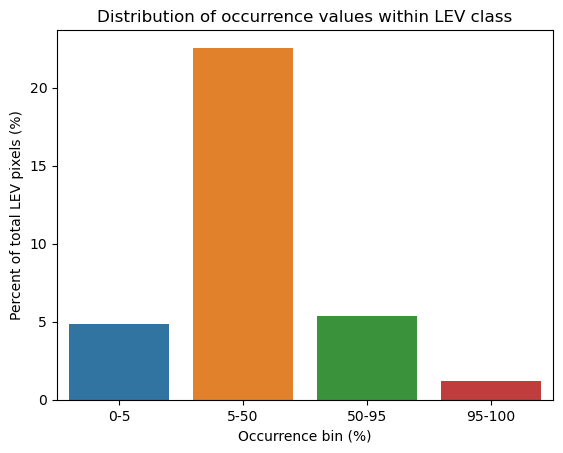

In [81]:
## Plot binned stat
## Plot hist to show: "Within all LEV, what was the binned distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)

# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()



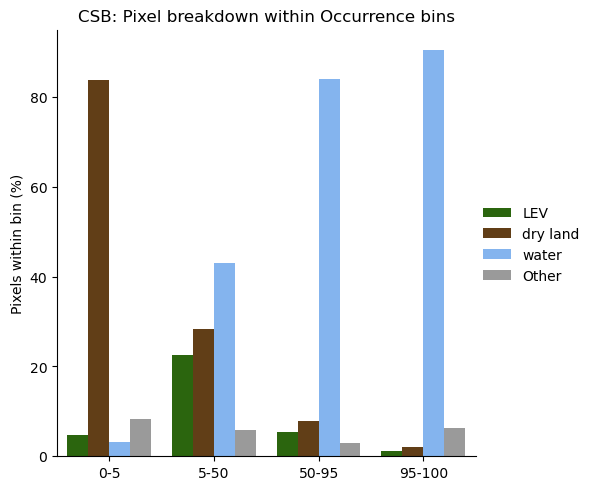

In [87]:
## Plot binned stat for all main classes as percentage of total pixels in bin (reshape first with pd.melt)
g = sns.catplot((cm_full.drop('SUM')/ cm_full.loc['SUM', :] * 100).reset_index().melt(id_vars='index', var_name='bin_R_edge'),\
     x = 'bin_R_edge', y='value', hue='index', kind='bar', palette=['#267300', '#6d3f0b', '#73b2ff', '#9a9a9a']) #
g.legend.set_title('')
g.set_axis_labels('', 'Pixels within bin (%)')
g.set(title=f'{region}: Pixel breakdown within Occurrence bins', xticklabels=bin_labels)

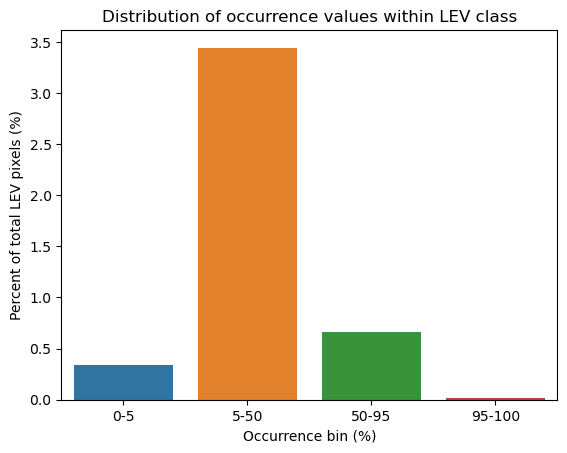

In [ ]:
## Plot binned stat in other dimension (TBD)
## Plot hist to show: "Within all of one occurrence bin, what was the contribution of LEV values"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)
# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title('Distribution of occurrence values within LEV class')
plt.show()



### Try to visualize confusion matrix

In [2]:
cm.iloc[:2, :-1]

NameError: name 'cm' is not defined

KeyError: (0, 0)

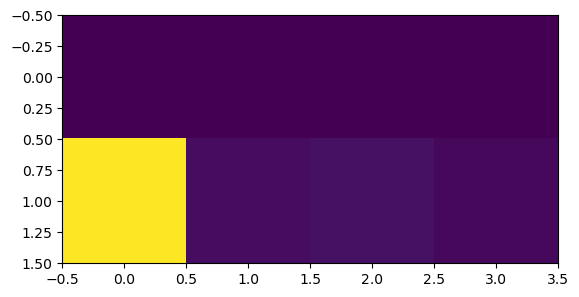

In [130]:
## Visualize CM
from sklearn.metrics import ConfusionMatrixDisplay
cmD = ConfusionMatrixDisplay(cm.iloc[:2, :])
# cmD.
cmD.plot()

### CM viz V2

In [152]:
## Add row sum
# cm.columns = ['0-5', '5-50', '50-95', '95-100'] # comment out if already run
# cm['SUM'] = cm.sum(axis=1)
cm.astype('int')

,0-5,5-50,50-95,95-100,SUM
LEV,171108,57047,14811,223,243189
SUM,50507184,1657152,2227264,1062964,55454564
Other,50336076,1600105,2212453,1062741,55211375


KeyError: (0, 0)

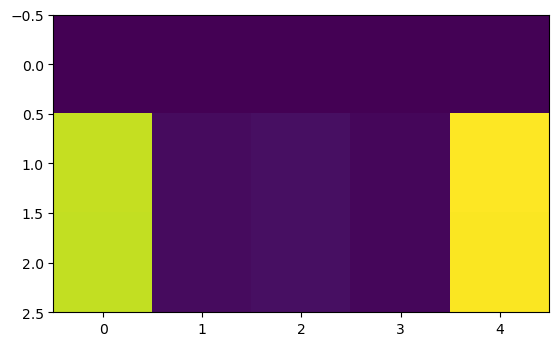

In [148]:
cmD = ConfusionMatrixDisplay(cm)
# cmD = ConfusionMatrixDisplay(cm.iloc[:2, :4])
# cmD.
cmD.plot()

## Method B: Load from lengthy GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Dissolve based on DN field to get only n entries corresponding to n classes
2. Zonal histogram based on DN field

In [30]:
## Load file that has already been aggregated through verrry slow QGIS dissolve by DN
df = gpd.read_file('/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/dissolved/zonal_hist/YFLATS_190914_mosaic_rcls_brn_ds_Occurrence.shp')
df.head()

,DN,geometry
0,35,"MULTIPOLYGON (((-2017546.705 3712282.011, -201..."
1,5,"MULTIPOLYGON (((-2034859.024 3717013.819, -203..."
2,4,"MULTIPOLYGON (((-2057236.298 3723637.221, -205..."
3,3,"MULTIPOLYGON (((-2058766.512 3723947.781, -205..."
4,2,"MULTIPOLYGON (((-2059381.986 3723834.850, -205..."
